In [2]:
%load_ext autoreload
%autoreload 2
import bayes3d as b3d
import bayes3d.genjax
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import jax.tree_util as jtu
import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import Diff
import trimesh
import pythreejs as p3s
# console = genjax.pretty(show_locals=False)
key = jax.random.PRNGKey(0)

pi = jnp.pi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#| export
# 
# Monkey patching `sample` for `BuiltinGenerativeFunction`
# 
cls = genjax._src.generative_functions.builtin.builtin_gen_fn.BuiltinGenerativeFunction

def genjax_sample(self, key, *args, **kwargs):
    _, tr = self.simulate(key, args)
    return tr.get_retval()

setattr(cls, "sample", genjax_sample)


# 
# Monkey patching `sample` for `DeferredGenerativeFunctionCall`
# 
cls = genjax._src.generative_functions.builtin.builtin_gen_fn.DeferredGenerativeFunctionCall

def deff_gen_func_call(self, key, **kwargs):
    return self.gen_fn.sample(key, *self.args, **kwargs)

def deff_gen_func_logpdf(self, x, **kwargs):
    return self.gen_fn.logpdf(x, *self.args, **kwargs)

setattr(cls, "__call__", deff_gen_func_call)
setattr(cls, "logpdf", deff_gen_func_logpdf)

In [3]:
from bayes3d._mkl.pose import pack_pose, unpack_pose, apply_pose, lift_pose, from_euler, look_at
from bayes3d._mkl.meshes import *
import numpy as np


fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T = len(_xs)

ps = jax.vmap(lift_pose)(_xs, _hds)


mesh = trimesh_from_2d_segs(_segs)
table   = create_cuboid(20, 20, -0.1)
table   = move_to_xy(table, *_center)
mesh.vertices[:,2] -= 0.5
table.vertices[:,2] -= 0.5

v = Viewer(cam_pos=(*_center,15), cam_look=np.array([*_center,0]), background="#eee", view_as="world")
v.add_mesh(mesh.vertices, mesh.faces, c=np.array([.99,.99,.99]))
v.add_mesh(table.vertices, table.faces, c=np.array([1.,1.,1.]))

for p in ps: v.add_pose(p, scale=0.5, width=2)

v

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.6, positio…

In [186]:
from genjax.generative_functions.distributions import ExactDensity

class DiagNormal(ExactDensity):
    # @jax.jit
    def sample(self, key, mus, sigs):
        keys = jax.random.split(key, len(mus))
        return jax.vmap(genjax.normal.sample)(keys, mus, sigs)

    # @jax.jit
    def logpdf(self, xs, mus, sigs):
        return jnp.sum(jax.vmap(genjax.normal.logpdf)(xs, mus, sigs))

diagnormal = DiagNormal()



In [187]:
key, = jax.random.split(key,1)
%timeit -n 1 -r 1 diagnormal.sample(key, jnp.zeros(3), jnp.ones(3));

5.06 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [188]:
from tensorflow_probability.substrates import jax as tfp
import jax
import jax.numpy as jnp
from bayes3d.transforms_3d import ( 
    quaternion_to_rotation_matrix as rot_from_quat,
    rotation_matrix_to_quaternion as quat_from_rot
)    
from jax.scipy.special import logsumexp

class VMF_Rotation(ExactDensity):
    """
    Van Mises-Fisher but in rotation space.

    - https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
    """
    # @jax.jit
    def sample(self, key, r0, k):
        q = tfp.distributions.VonMisesFisher(
            jnp.array([1.0, 0.0, 0.0, 0.0]), k
        ).sample(seed=key)

        r = rot_from_quat(q)
        return r0 @ r

    def logpdf(self, r, r0, k):
        q0 = quat_from_rot(r0)
        q  = quat_from_rot(r)
        logp = tfp.distributions.VonMisesFisher(
            q0, k
        ).log_prob(q)

        return logp

vmf_rotation = VMF_Rotation()

In [189]:
r0 = from_euler(pi/2,0,0)
key, = jax.random.split(key,1)

%timeit -n 1 -r 1 vmf_rotation.sample(key, r0, 1.0)

1.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


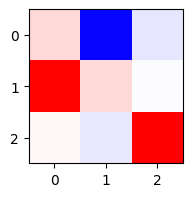

In [172]:
r0 = from_euler(pi/2,0,0)
r = vmf_rotation.sample(key, r0, 1_000.0)
# -------------------
plt.figure(figsize=(2,2))
plt.imshow(r, vmin=-1, vmax=1, cmap="bwr")

In [200]:
from collections import namedtuple
Control = namedtuple("Control", ["dx", "dr"])


@genjax.gen
def motion_model(p, u, x_noise, r_concentration):
    x, r   = unpack_pose(p)
    dx, dr = u.dx, u.dr

    x_ = diagnormal(x + dx, x_noise*jnp.ones(3)) @ "x"
    r_ = vmf_rotation(dr@r, r_concentration) @ "r"

    return pack_pose(x_, r_)


x0 = jnp.zeros(3)
r0 = from_euler(pi/2,0,0)
p0 = pack_pose(x0,r0)
u = Control(jnp.array([1,0,0]), from_euler(10/180*pi,0.0,0.0))

model_args = (p0, u, 0.1, 100.0)

motion_model_sample = jax.jit(motion_model.sample)

In [193]:
key, = jax.random.split(key,1)

%timeit -n 1 -r 1 motion_model.simulate(key, model_args)

4.62 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [202]:
key, = jax.random.split(key,1)
%timeit -n 1 -r 1 motion_model_sample(key, *model_args)

797 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [227]:
x0 = jnp.zeros(3)
r0 = from_euler(0,0,0)
p0 = pack_pose(x0,r0)
ps = [p0]

u = Control(r0[:,0], from_euler(0.01/180*pi,0.0,0.0))

for t in range(10):
    print(t)
    key, = jax.random.split(key,1)

    x,r = unpack_pose(ps[-1])
    u = Control(0.25*r[:,0], from_euler(1/180*pi,0.0,0.0))
    model_args = (ps[-1], u, 0.001, 1_000.0)


    p = motion_model_sample(key, *model_args)
    ps.append(p)



0
1
2
3
4
5
6
7
8
9


In [229]:
v = Viewer(cam_pos=(0,0,10), cam_look=np.array([0,0,0]), background="#eee", view_as="world")
table   = create_cuboid(5.2, 5.2, -0.1)
table   = move_to_xy(table,0,0)
# v.add_mesh(table.vertices, table.faces, c=np.array([1.,1.,1.]))
for p in ps: v.add_pose(p, scale=0.2, width=4)

v

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.6, positio…